Wybrany zbiór danych:
https://physionet.org/content/accelerometry-walk-climb-drive/1.0.0/

# Analiza szeregów czasowych przy użyciu biblioteki tsai

# Instalacja biblioteki tsai i import

In [ ]:
# # **************** UNCOMMENT AND RUN THIS CELL IF YOU NEED TO INSTALL/ UPGRADE TSAI ****************
stable = True # Set to True for latest pip version or False for main branch in GitHub
!pip install {"tsai -U" if stable else "git+https://github.com/timeseriesAI/tsai.git"} >> /dev/null

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchaudio 2.3.0+cu121 requires torch==2.3.0, but you have torch 2.2.2 which is incompatible.
torchtext 0.18.0 requires torch>=2.3.0, but you have torch 2.2.2 which is incompatible.


In [ ]:
from tsai.all import *
import sklearn.metrics as skm
my_setup()

os              : Linux-6.1.85+-x86_64-with-glibc2.35
python          : 3.10.12
tsai            : 0.3.9
fastai          : 2.7.15
fastcore        : 1.5.38
torch           : 2.2.2+cu121
device          : cpu
cpu cores       : 1
threads per cpu : 2
RAM             : 12.67 GB
GPU memory      : N/A


# Podłącz Dysk Google

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Zmień working directory

In [ ]:
%cd /content/drive/MyDrive/Colab\ Notebooks/HCI\ -\ UM

/content/drive/MyDrive/Colab Notebooks/HCI - UM


# Aktualna ścieżka

In [ ]:
!pwd

/content/drive/MyDrive/Colab Notebooks/HCI - UM


# Rozpakuj skompresowany folder (wykonaj raz)

In [ ]:
# !unzip labeled-raw-accelerometry-data-captured-during-walking-stair-climbing-and-driving-1.0.0.zip -d . >> /dev/null

# Sprawdź zawartość folderu

In [ ]:
import os

directory = './labeled-raw-accelerometry-data-captured-during-walking-stair-climbing-and-driving-1.0.0/raw_accelerometry_data'

# pliki w folderze
files = os.listdir(directory)

for f in files:
  print(f)

idc735fc09.csv
id687ab496.csv
id1f372081.csv
id5993bf4a.csv
idf1ce9a0f.csv
idff99de96.csv
id9603e9c3.csv
id1165e00c.csv
id3e3e50c7.csv
id34e056c8.csv
id4ea159a8.csv
idf5e3678b.csv
id8af5374b.csv
id7c20ee7a.csv
id8e66893c.csv
ida61e8ddf.csv
idf540d82b.csv
idbae5a811.csv
idfc5f05e4.csv
id1c7e64ad.csv
idd80ac2b4.csv
id37a54bbf.csv
idecc9265e.csv
idb221f542.csv
id00b70b13.csv
id5308a7d6.csv
id86237981.csv
id82b9735c.csv
idabd0c53c.csv
idc91a49d0.csv
id079c763c.csv
id650857ca.csv


# Czytaj pliki

In [ ]:
import pandas as pd
import numpy as np

In [ ]:
# stwórz pełne ścieżki dla każdego pliku
file_list = []
for f in files:
  if os.path.isfile(os.path.join(directory, f)):
    file_list.append(os.path.join(directory, f))

dataframes = [pd.read_csv(f) for f in file_list]

# Przetwórz dane

In [ ]:
# listy do przechowywania sekwencji o konkretnych etykietach
data_list_w_label_1 = []
data_list_w_label_2 = []
data_list_w_label_3 = []
data_list_w_label_4 = []

In [ ]:
def trim_to_len(seq, seq_size):
  '''
  Funkcja skraca sekwencję (listę) danych do najwyższej ustalonej długości, w której można wydzielić równe podsekwencje o określonej długości.
  seq: aktualna sekwencja danych
  seq_size: oczekiwana długość podsekwencji w aktualnej sekwencji
  Zwraca skróconą sekwencję (listę) danych.
  '''
  length = len(seq)
  target_length = (length // seq_size) * seq_size
  return seq[:target_length]

for df in dataframes:
  # usuń wiersze z activity = 99 (nieokreślone czynności)
  df = df[df['activity'] != 99]
  # sortuj wiersze rosnąco po kolumnie 'activity' (wtedy będzie 'płynnie' przechodzić po danych o kolejnych aktywnościach)
  df.sort_values(by=['activity'])

  # do przechowywania danych (list) dla poszczególnych nr aktywności
  activity_seqs = {1: [], 2: [], 3: [], 4: []}
  curr_seq = []

  # przechodź po kolejnych wierszach
  for _, row in df.iterrows():
    activity = row['activity']
    # jeśli wiersz z istotną aktywnością (etykietą), dodaj ją do aktualnej sekwencji
    if activity in [1, 2, 3, 4]:
      curr_seq.append(row)
    # jeśli wystąpi 'przerywnik' między aktywnościami
    elif activity == 77:
      # jeśli coś znajduje się w aktualnej sekwencji, dodaj ją całą do nr aktywności, do której przynależy
      if curr_seq:
        activity_seqs[curr_seq[0]['activity']].append(curr_seq)
        curr_seq = []
  # ostatnia sekwencja po wyjściu z pętli
  if curr_seq:
    activity_seqs[curr_seq[0]['activity']].append(curr_seq)

  # przechodź po kolejnych listach zapisanych sekwencji, kolejno dla każdej aktywności
  for activity, seq_list in activity_seqs.items():
    # najpierw dla każdej sekwencji w liście dla aktywności poskaracaj je do rozmiaru, z którego można wydzielić podsekwencje o ustalonej długości
    trimmed_seqs = [trim_to_len(seq, 300) for seq in seq_list]
    # zapisuj kolejne listy sekwencji w liście dla odpowiedniej etykiety
    if activity == 1:
      data_list_w_label_1.extend([pd.DataFrame(seq).astype({'activity': 'int'}) for seq in trimmed_seqs])
    elif activity == 2:
      data_list_w_label_2.extend([pd.DataFrame(seq).astype({'activity': 'int'}) for seq in trimmed_seqs])
    elif activity == 3:
      data_list_w_label_3.extend([pd.DataFrame(seq).astype({'activity': 'int'}) for seq in trimmed_seqs])
    elif activity == 4:
      data_list_w_label_4.extend([pd.DataFrame(seq).astype({'activity': 'int'}) for seq in trimmed_seqs])

In [ ]:
# połącz poszczególne sekwencje w jednej ciąg
data_list_w_label_1 = pd.concat(data_list_w_label_1, ignore_index=True)
data_list_w_label_2 = pd.concat(data_list_w_label_2, ignore_index=True)
data_list_w_label_3 = pd.concat(data_list_w_label_3, ignore_index=True)
data_list_w_label_4 = pd.concat(data_list_w_label_4, ignore_index=True)

In [ ]:
# ujednolicenie długości danych dla wszystkich aktywności
min_len = min(len(data_list_w_label_1), len(data_list_w_label_2), len(data_list_w_label_3), len(data_list_w_label_4))

data_list_w_label_1t = data_list_w_label_1[:min_len]
data_list_w_label_2t = data_list_w_label_2[:min_len]
data_list_w_label_3t = data_list_w_label_3[:min_len]
data_list_w_label_4t = data_list_w_label_4[:min_len]

In [ ]:
# połącz wszystkie dane w jeden długi ciąg, gdzie aktywności będą pojawiać się w kolejności rosnącej
full_df = pd.concat([data_list_w_label_1t, data_list_w_label_2t, data_list_w_label_3t, data_list_w_label_4t], ignore_index=True)

In [ ]:
# zamień miejscami kolumny aktywności i czasu (dla przetworzenia w sliding window)
cols = full_df.columns.tolist()
cols[0], cols[1] = cols[1], cols[0]
full_df = full_df[cols]

# zresetuj czasowe zmiany w szeregu czasowym, aby kolejno przechodziły co 0.01s
full_df.reset_index(drop=True, inplace=True)
full_df.loc[:, 'time_s'] = [(i + 1) * 0.01 for i in range(len(full_df))]

# Sprawdź dane

In [ ]:
nan_in_df = full_df.isnull().sum().any()
nan_in_df

False

In [ ]:
any_zero = (full_df == 0).sum()
any_zero

time_s         0
activity       0
lw_x        5174
lw_y        1101
lw_z        3651
lh_x        2935
lh_y         109
lh_z        4195
la_x        3425
la_y         428
la_z        3343
ra_x        2664
ra_y         440
ra_z        3891
dtype: int64

In [ ]:
full_df.shape

(954000, 14)

# Przygotuj timeseries do uczenia modelu

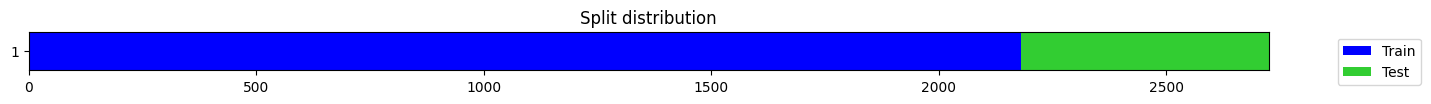

(#2725) [(TSTensor(vars:12, len:350, device=cpu, dtype=torch.float32), TensorCategory(2)), (TSTensor(vars:12, len:350, device=cpu, dtype=torch.float32), TensorCategory(2)), (TSTensor(vars:12, len:350, device=cpu, dtype=torch.float32), TensorCategory(2)), (TSTensor(vars:12, len:350, device=cpu, dtype=torch.float32), TensorCategory(1)), (TSTensor(vars:12, len:350, device=cpu, dtype=torch.float32), TensorCategory(1)), (TSTensor(vars:12, len:350, device=cpu, dtype=torch.float32), TensorCategory(2)), (TSTensor(vars:12, len:350, device=cpu, dtype=torch.float32), TensorCategory(2)), (TSTensor(vars:12, len:350, device=cpu, dtype=torch.float32), TensorCategory(0)), (TSTensor(vars:12, len:350, device=cpu, dtype=torch.float32), TensorCategory(0)), (TSTensor(vars:12, len:350, device=cpu, dtype=torch.float32), TensorCategory(3))] ...]

In [ ]:
window_length = 350          # window_length is usually selected based on prior domain knowledge or by trial and error
stride = None                # None for non-overlapping (stride = window_length) (default = 1). This depends on how often you want to predict once the model is trained
start = 0                    # use all data since the first time stamp (default = 0)
get_x = full_df.columns[2:]  # Indicates which are the columns that contain the x data.
get_y = 'activity'           # In multivariate time series, you must indicate which is/are the y columns
# horizon = 0                # 0 means y is taken from the last time stamp of the time sequence (default = 0)
seq_first = True

# pomieszaj dane w df:
# rozmiar podzbioru
chunk_size = 350
# na ile podbiorów df podzielić
num_chunks = len(full_df) // chunk_size
# odpowiednio podziel df na podzbiory
chunks = np.array_split(full_df, num_chunks)
# pomieszaj je
np.random.shuffle(chunks)
# ponownie połącz w jeden ciąg
full_df_new = pd.concat(chunks, ignore_index=True)

# podziel dane na równe zbiory na których będzie bazował model (do uczenia i weryfikacji)
X, y = SlidingWindow(window_length, stride=stride, start=start, get_x=get_x,  get_y=get_y, seq_first=seq_first)(full_df_new)
splits = get_splits(y, valid_size=.2, stratify=True, random_state=23, shuffle=False)
tfms  = [None, [Categorize()]]
dsets = TSDatasets(X, y, tfms=tfms, splits=splits)
dsets

In [ ]:
dls = TSDataLoaders.from_dsets(dsets.train, dsets.valid, bs=[64, 128], batch_tfms=[TSStandardize()], num_workers=0)

# Zwizualizuj próbkę

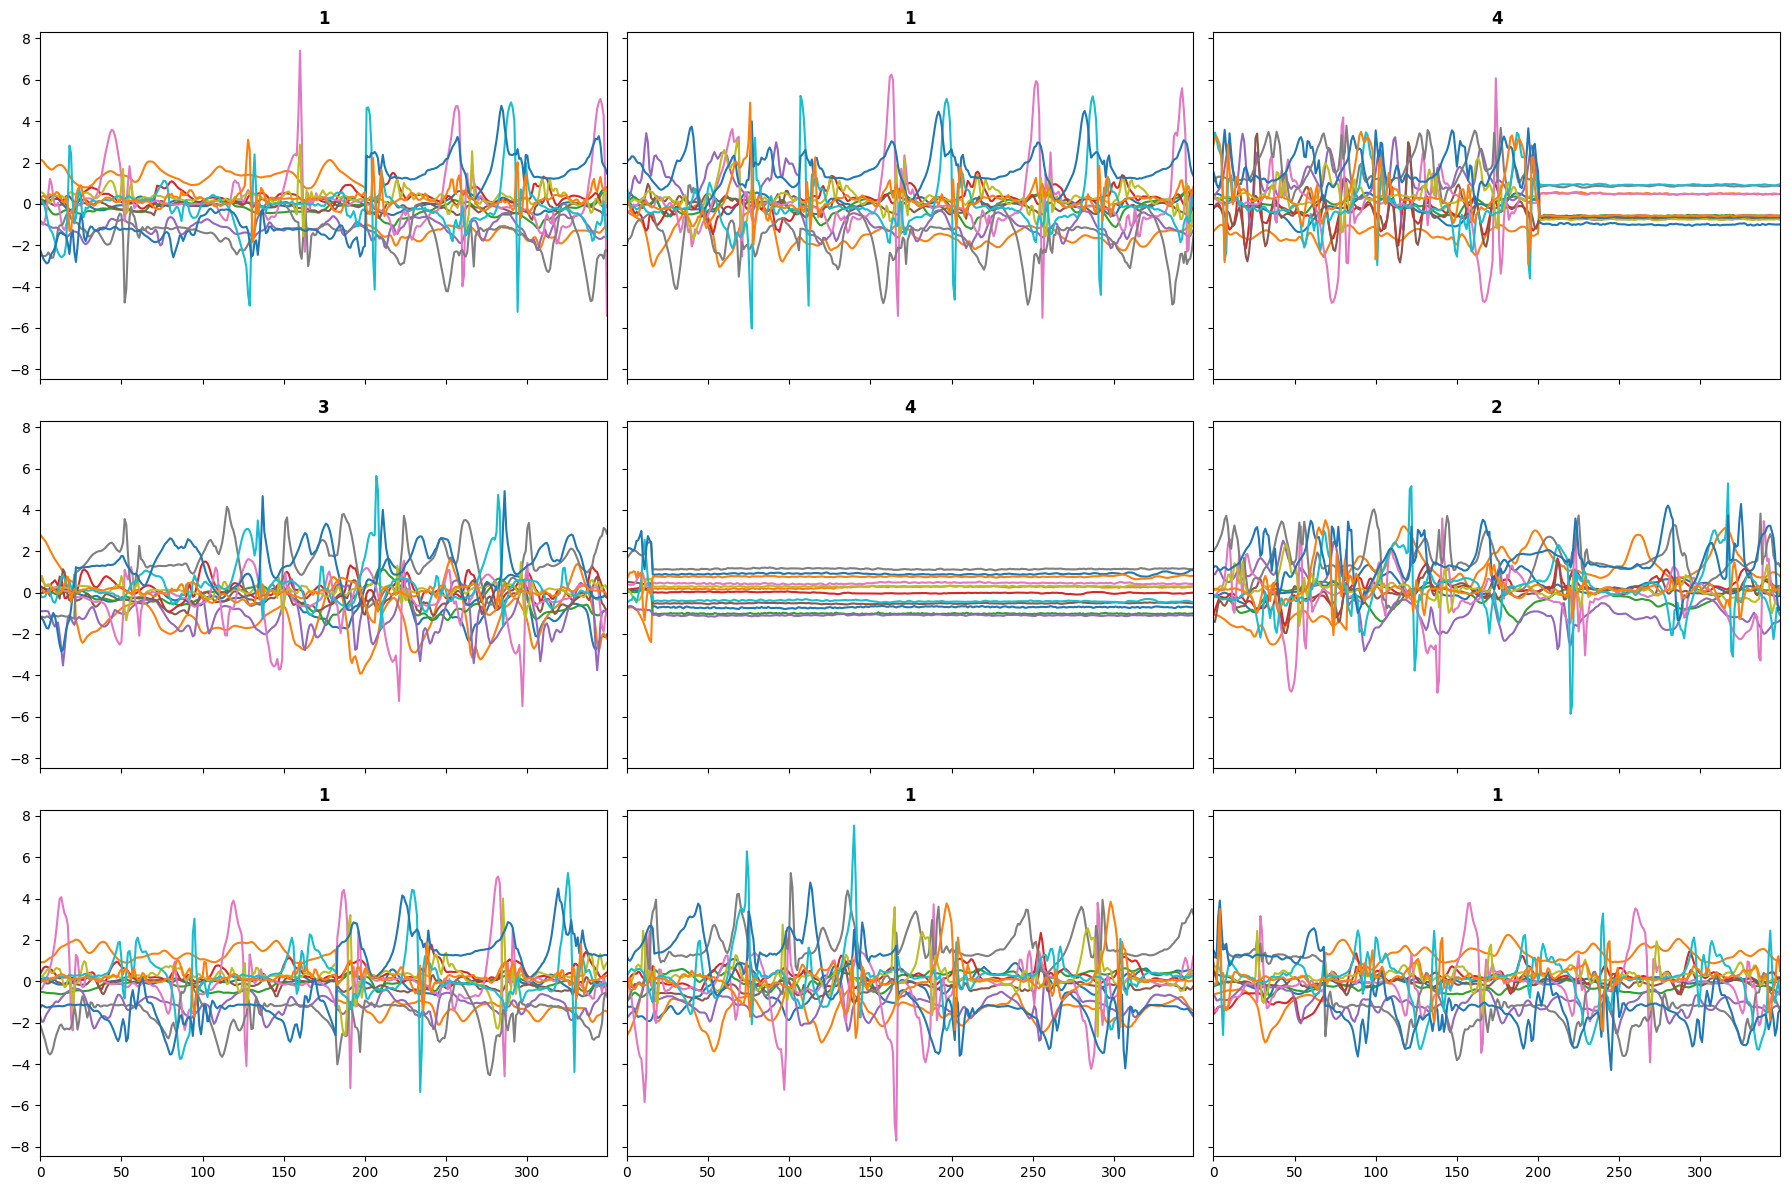

In [ ]:
dls.show_batch(sharey=True)

# Learner

In [ ]:
model = InceptionTime(dls.vars, dls.c)
learn = Learner(dls, model, metrics=accuracy)

# LR find

SuggestedLRs(valley=0.0003311311302240938)

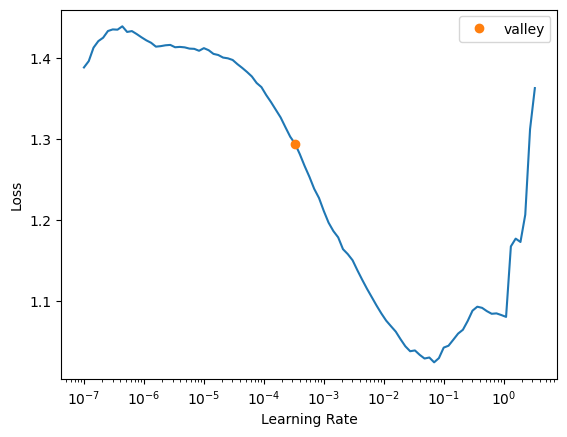

In [ ]:
learn.lr_find()

# Trenowanie

In [ ]:
learn.fit_one_cycle(15, lr_max=1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,1.026966,1.271049,0.425688,01:52
1,0.776059,1.461326,0.491743,01:48
2,0.614965,1.719105,0.453211,01:48
3,0.490001,1.121448,0.467890,01:48
4,0.362501,0.961027,0.563303,01:48
5,0.269237,1.256716,0.563303,01:49
6,0.199094,0.886566,0.642202,01:48
7,0.143215,0.565493,0.746789,01:46
8,0.108736,0.633887,0.700917,01:47
9,0.081434,0.418519,0.836697,01:47


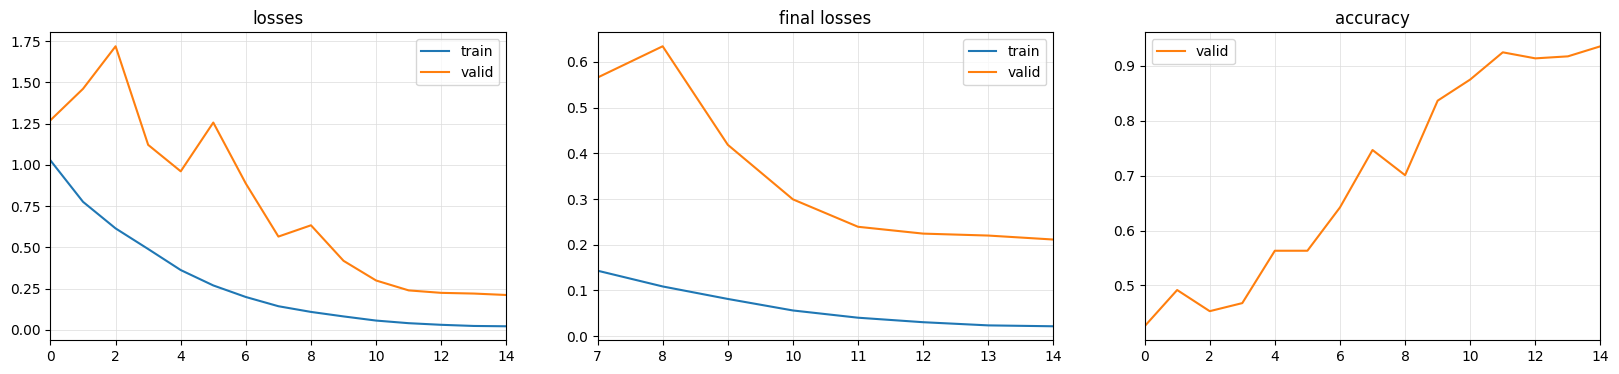

In [ ]:
learn.plot_metrics()

# Rezultaty

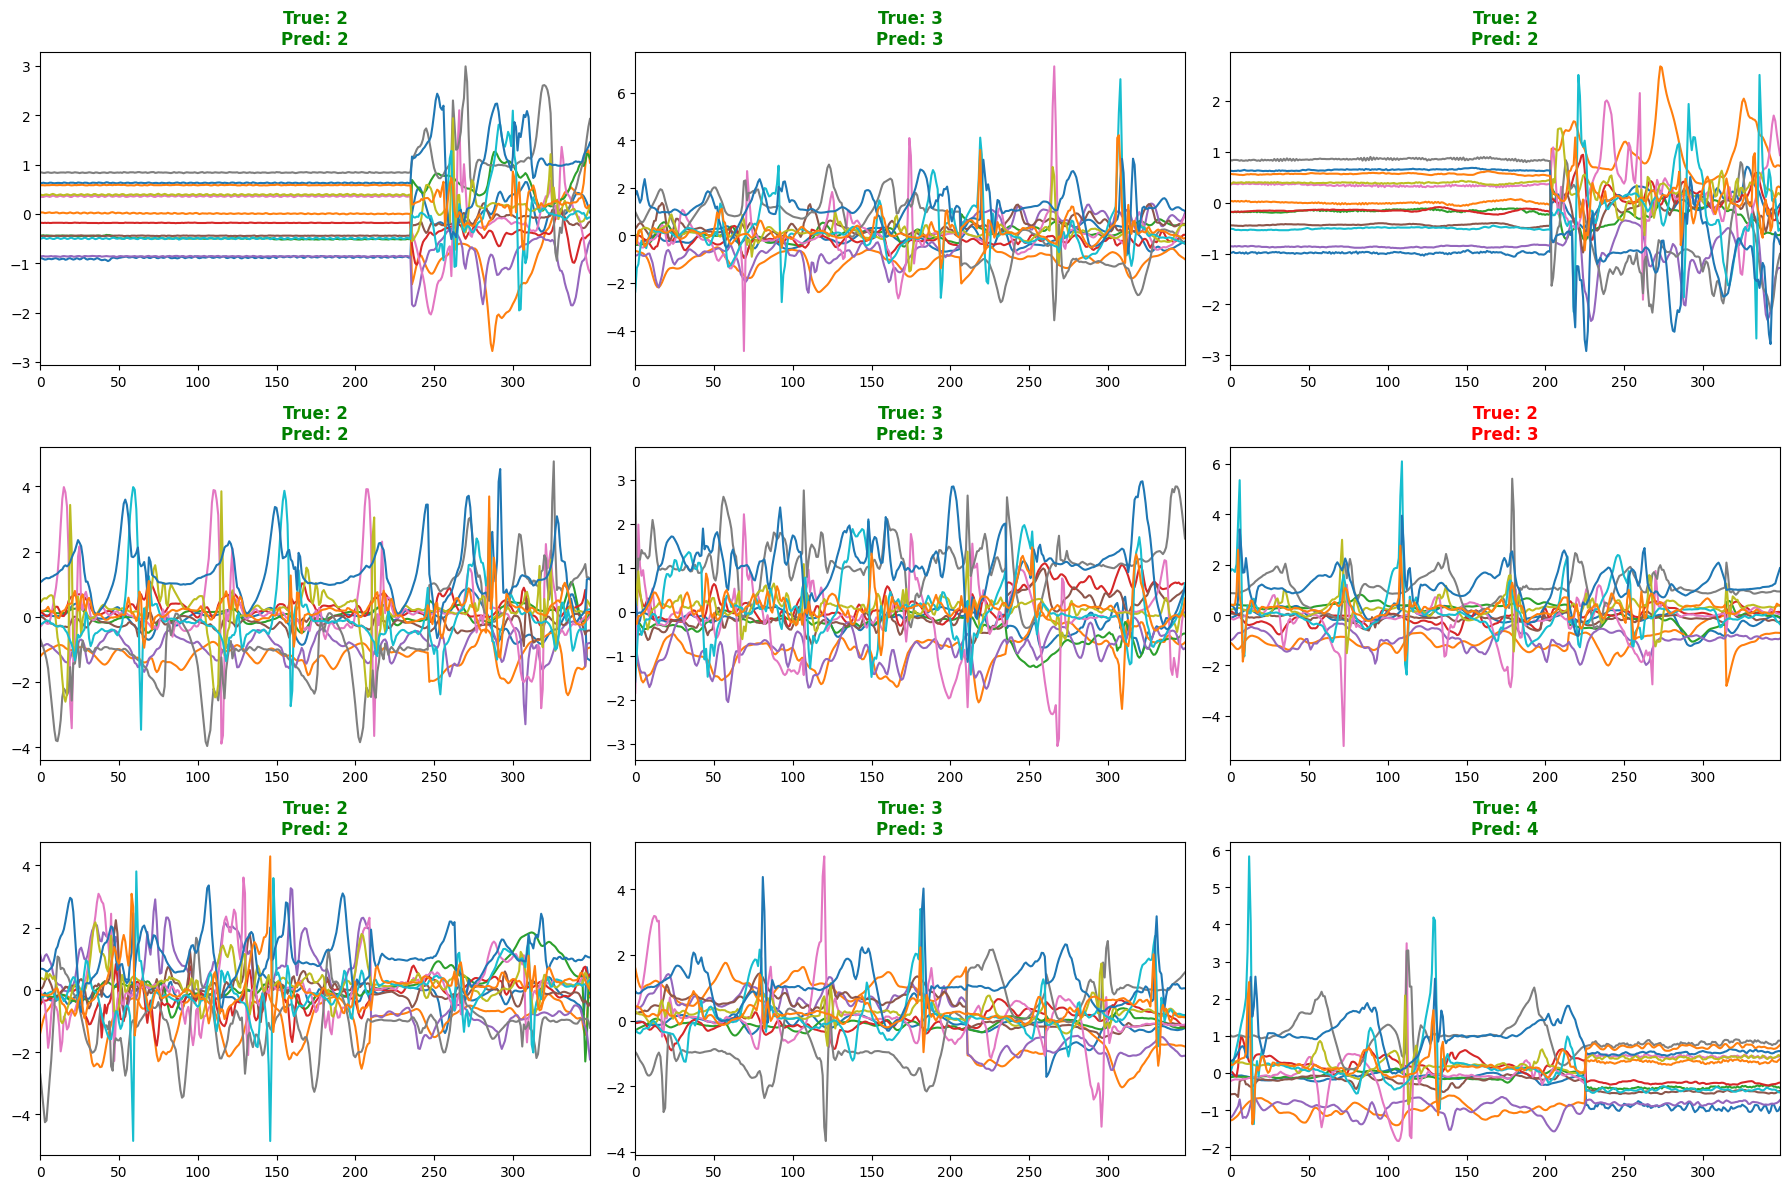

In [ ]:
learn.show_results()

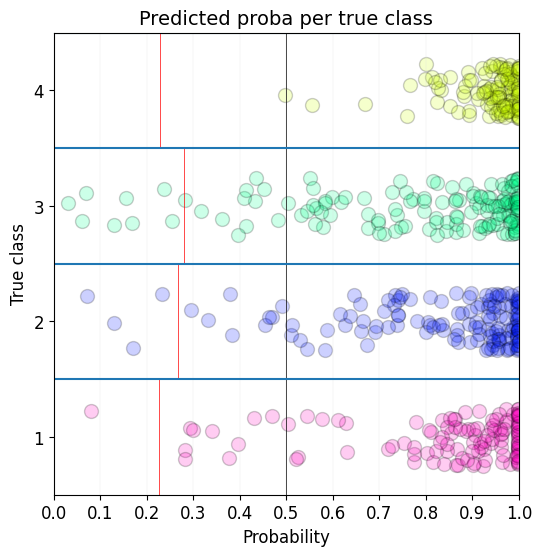

In [ ]:
learn.show_probas()

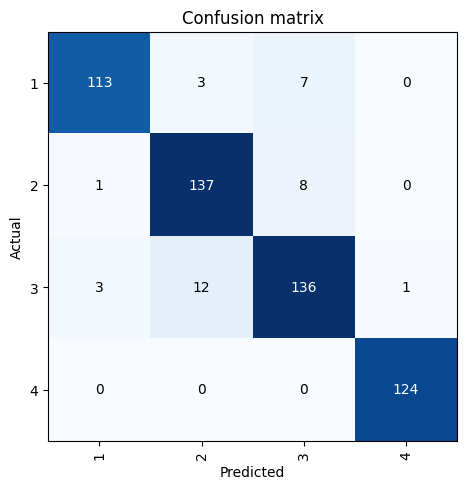

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

---

# Analiza szeregów czasowych przy użyciu biblioteki catch22

# Zainstaluj catch22 dla Python

In [ ]:
!pip install pycatch22 >> /dev/null

# Import biblioteki catch22

In [ ]:
import pycatch22

In [ ]:
# Dla pojedynczej kolumny:
# full_df_catch22 = full_df[['activity', 'lw_x']]

# Dla wszystkich kolumn:
full_df_catch22 = full_df[['activity'] + list(full_df.columns[2:])]

In [ ]:
# pomieszaj wydzielone podzbiory z df:
# rozmiar podzbioru
ts_size = 300
# na ile podbiorów df podzielić
ts_num = len(full_df_catch22) // ts_size
# odpowiednio podziel df na podzbiory
tss = np.array_split(full_df_catch22, ts_num)
# pomieszaj je
np.random.shuffle(tss)

# catch22

In [ ]:
# etykiety i cechy dla poszczególnych podzbiorów (ich kolumn)
# features = [] # dla pojedynczej kolumny

labels = []
tss_cols_features = []

Dla pojedynczej kolumny:

In [ ]:
# # dla kolejnych podzbiorów
# for ts in tss:
#   # zapamiętaj etykietę aktualnego podzbioru
#   labels.append(list(set(ts['activity']))[0])

#   # dla kolumny podzbioru wylicz jej cechy i zapamiętaj ich wartości
#   col_to_lst = ts['lw_x'].tolist()
#   features_dict = pycatch22.catch22_all(col_to_lst)
#   features.append(features_dict['values'])

Dla wszystkich kolumn:

In [ ]:
# dla kolejnych podzbiorów
for ts in tss:
  # zapamiętaj etykietę aktualnego podzbioru
  labels.append(list(set(ts['activity']))[0])

  # wartości cech dla kolejnych kolumn podzbioru
  ts_features = []

  # dla każdej kolumny podzbioru wylicz jej cechy i zapamiętaj ich wartości
  for col in ts:
    col_to_lst = ts[col].tolist()

    features = pycatch22.catch22_all(col_to_lst)

    ts_features.append(features['values'])

  # zapamietaj wartości cech każdej kolumny dla aktualnego podzbioru
  tss_cols_features.append(ts_features)

In [ ]:
# Dla pojedynczej kolumny:
# X = np.array(features)

# Dla wszystkich kolumn:
X = np.array([np.concatenate(ts_cols) for ts_cols in tss_cols_features])
X = np.nan_to_num(X, nan=0)

y = np.array(labels)

# Kros-walidacja i predykcja

In [ ]:
from sklearn import svm
from sklearn.model_selection import KFold
from sklearn.metrics import matthews_corrcoef

In [ ]:
# stwórz pętlę kros-walidacyjną
# default: n_splits = 5
kf = KFold()

results = []

for train_index, test_index in kf.split(X):
  X_train, X_test = X[train_index], X[test_index]
  y_train, y_test = y[train_index], y[test_index]

  # uczenie modelu
  clf = svm.SVC()
  clf.fit(X_train, y_train)

  # predykcja danych testowych
  y_pred = clf.predict(X_test)

  # wynik uczenia
  result = matthews_corrcoef(y_test, y_pred)
  results.append(result)

# uśrednienie otrzymanych wyników
avg_result = np.mean(results)

In [ ]:
avg_result

0.9459905580960075